In [29]:
%reload_ext autoreload
%autoreload 2

In [30]:
from catboost import CatBoostClassifier
import catboost 

import pandas as pd
import json
from pandas import json_normalize
from tqdm import tqdm_notebook as tqdm
import numpy as np
import ast
import json

import sys
import os
sys.path.append(os.path.join(sys.path[0], '../../'))

from core.train_utils import calculate_roi, get_winner_favorite, combine_df

pd.set_option('display.precision',6)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
print(pd.__version__, catboost.__version__, np.__version__)

1.2.4 0.22 1.20.2


In [31]:
with open('./data_models/generated_features_11.05.2021.txt', 'r') as outfile:
    generated_features = json.load(outfile)
fighter1_stats = generated_features['fighter1_stats']
fighter2_stats = generated_features['fighter2_stats']
difference_cols = generated_features['difference_cols']

cat_cols = ['city', 'country', 'is_fight_night', 'weightCategory.id', 
              'f1_country', 'f2_country', 'f1_city', 'f2_city']

train_cols = cat_cols + fighter1_stats + fighter2_stats# + difference_cols #+ ['f1_odds', 'f2_odds', 'odds_difference']# +  #['f1_odds', 'f2_odds', 'odds_difference'] +

In [36]:
df = pd.read_csv('./data_models/events_joined_total_11.05.2021.csv', index_col=0)
df['eventDate.date'] = pd.to_datetime(df['eventDate.date'])
df['weightCategory.id'] = df['weightCategory.id'].astype('object')
df['winner'] = df['winnerId'] == df['fighterId_1']
print(df.shape)

df[cat_cols] = df[cat_cols].fillna('unknown')
df = df[(df['f1_count_of_fights'] >= 1) & (df['f2_count_of_fights'] >= 1)]

train1 = df[(df['eventDate.date'].dt.year > 2005) & (df['eventDate.date'].dt.year < 2020) &
           ((df['type']=='straight'))]

val1  = df[(df['eventDate.date'].dt.year == 2020) & (df['eventDate.date'].dt.year < 2021) &
          ((df['type']=='straight'))]
val1 = val1.reset_index()
val1 = val1[~val1['odds_difference'].isna()]
# 'f1_timezone', 'f2_timezone', 'timezone', 'f1_name', 'f2_name', 


train2 = df[(df['eventDate.date'].dt.year > 2005) & (df['eventDate.date'].dt.year < 2020) &
           ((df['type']=='reversed'))]

val2  = df[(df['eventDate.date'].dt.year == 2020) & (df['eventDate.date'].dt.year < 2021) &
          ((df['type']=='reversed'))]
val2 = val2.reset_index()
val2 = val2[~val2['odds_difference'].isna()]

print(train1.shape, val1.shape)
print(train2.shape, val2.shape)

(11854, 343)
(7130, 343) (554, 344)
(3565, 343) (277, 344)


In [37]:
test1  = df[(df['eventDate.date'].dt.year == 2021) & 
          ((df['type']=='straight'))]
test1 = test1.reset_index()
test1 = test1[~test1['odds_difference'].isna()]

test2  = df[(df['eventDate.date'].dt.year == 2021) & 
          ((df['type']=='reversed'))]
test2 = test2.reset_index()
test2 = test2[~test2['odds_difference'].isna()]

test1.shape

(100, 344)

In [38]:
# cat_features = np.where(train1[train_cols].dtypes == 'object')[0]

X_train = train1[train_cols]#.drop(['f1_odds', 'f2_odds', 'odds_difference'], axis=1)
y_train = train1['winner'].astype(int)

X_val = val1[train_cols]#.drop(['f1_odds', 'f2_odds', 'odds_difference'], axis=1)
y_val = val1['winner'].astype(int)

print(X_train.shape, X_val.shape)
clf1 = CatBoostClassifier(iterations=3000, 
                           depth=3,
                           learning_rate=0.001,
                           grow_policy='Depthwise', #SymmetricTree Depthwise
                           border_count=254,
                           colsample_bylevel=0.4,
                           subsample=0.2,
                           l2_leaf_reg=5,
                           eval_metric='Accuracy',
                           boosting_type='Plain', # 'Plain'
                           bootstrap_type='Bernoulli',# 'Bernoulli' Bayesian
                           sampling_frequency='PerTree',
                           max_ctr_complexity=5,
                           has_time=True,
                           task_type='CPU',
                           cat_features=[0,1,2,3,4,5,6,7],
#                            cat_features=cat_features,
                          use_best_model=False,
                          )


clf1.fit(X_train, y_train, plot=True, eval_set=(X_val, y_val), verbose=False)

# clf1.save_model('./data_models/catboost_v1_1_13.04.2021_1.cat')
clf1.get_feature_importance(prettified=True)#[:50]['Feature Id'].values

(7130, 218) (554, 218)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,Feature Id,Importances
0,f1_legSwing,31.794666
1,f2_legSwing,31.772750
2,city,3.621614
3,f2_age,2.624492
4,f1_age,2.513253
...,...,...
213,f1_def_knockdowns_PM,0.000000
214,f2_cumsum_knockdowns,0.000000
215,f2_cumsum_def_knockdowns,0.000000
216,f2_knockdowns_PM,0.000000


In [11]:
X_train = train2[train_cols]#.drop(['f1_odds', 'f2_odds', 'odds_difference'], axis=1)
y_train = train2['winner'].astype(int)

X_val = val2[train_cols]#.drop(['f1_odds', 'f2_odds', 'odds_difference'], axis=1)
y_val = val2['winner'].astype(int)

clf2  = CatBoostClassifier(iterations=3000, 
                           depth=3,
                           learning_rate=0.001,
                           grow_policy='Depthwise', #SymmetricTree Depthwise
                           border_count=254,
                           colsample_bylevel=0.4,
                           subsample=0.2,
                           l2_leaf_reg=5,
                           eval_metric='Accuracy',
                           boosting_type='Plain', # 'Plain'
                           bootstrap_type='Bernoulli',# 'Bernoulli' Bayesian
                           sampling_frequency='PerTree',
                           max_ctr_complexity=5,
                           has_time=True,
                           task_type='CPU',
                           cat_features=[0,1,2,3,4,5,6,7],
#                            cat_features=cat_features,
                          use_best_model=False,
                          )



clf2.fit(X_train, y_train, plot=True, eval_set=(X_val, y_val), verbose=False)

# clf2.save_model('./data_models/catboost_v1_1_13.04.2021_2.cat')
clf2.get_feature_importance(prettified=True)#[:50]['Feature Id'].values

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,Feature Id,Importances
0,legSwing_difference,46.299987
1,f1_legSwing,7.909731
2,age_difference,6.575321
3,f2_legSwing,4.396295
4,def_hits_PM_difference,3.053931
...,...,...
318,f2_def_knockdowns_PM,0.000000
319,cumsum_knockdowns_difference,0.000000
320,cumsum_def_knockdowns_difference,0.000000
321,knockdowns_PM_difference,0.000000


In [12]:
clf2.get_feature_importance(prettified=True)['Feature Id'].values

array(['legSwing_difference', 'f1_legSwing', 'age_difference',
       'f2_legSwing', 'def_hits_PM_difference', 'f2_age',
       'def_accentedHits_PM_difference', 'def_hitsHead_PM_difference',
       'f2_def_hits_PM', 'def_accentedHits_accuracy_difference',
       'takedown_PM_difference', 'f1_age', 'f1_def_hits_PM',
       'def_hitsHead_accuracy_difference', 'def_hits_accuracy_difference',
       'f2_def_hitsHead_PM', 'f2_def_accentedHits_PM',
       'armSpan_difference', 'accentedHitsPositionParter_PM_difference',
       'f1_def_hits_accuracy',
       'def_accentedHitsPositionDistance_PM_difference', 'f2_city',
       'cumsum_takedownSuccessful_difference',
       'def_accentedHitsPositionDistance_accuracy_difference',
       'def_accentedHitsPositionParter_PM_difference',
       'win_streak_difference', 'f1_def_hitsHead_accuracy',
       'f2_def_accentedHitsPositionDistance_accuracy', 'f2_takedown_PM',
       'f1_def_accentedHits_accuracy', 'hitsHead_PM_difference',
       'cumsum_de

In [13]:
print('Точность букмейкера')
val1['bookmaker_bet'] = (val1['f1_odds'] < val1['f2_odds']).astype(int)
(val1['bookmaker_bet'] == val1['winner']).mean()

Точность букмейкера


0.6353790613718412

In [14]:
y_proba = clf1.predict_proba(val1[clf1.feature_names_])
val1['y_proba'] = y_proba[:,1]
val1['y_pred'] = val1['y_proba'] > 0.5

y_proba = clf2.predict_proba(val2[clf2.feature_names_])
val2['y_proba'] = y_proba[:,1]
val2['y_pred'] = val2['y_proba'] > 0.5

val1['y_proba_comb'] = (val1['y_proba'] + 1-val2['y_proba']) / 2
val1['y_pred_comb'] = val1['y_proba_comb'] > 0.5

(val1['y_pred'] != val2['y_pred']).mean()

0.9855595667870036

In [15]:
calculate_roi(val1, pred_col='y_pred')
calculate_roi(val2, pred_col='y_pred')
calculate_roi(val1, pred_col='y_pred_comb')

  0%|          | 0/277 [00:00<?, ?it/s]

{'accuracy:': 0.5306859205776173,
 'bets_count:': 277,
 'finish_bank:': -1695.0,
 'roi:': -6.11913357400722}


  0%|          | 0/277 [00:00<?, ?it/s]

{'accuracy:': 0.5379061371841155,
 'bets_count:': 277,
 'finish_bank:': -1386.0,
 'roi:': -5.003610108303249}


  0%|          | 0/277 [00:00<?, ?it/s]

{'accuracy:': 0.5342960288808665,
 'bets_count:': 277,
 'finish_bank:': -1526.0,
 'roi:': -5.509025270758123}


In [16]:
same_preds = val1[val1['y_pred'] != val2['y_pred']]
calculate_roi(same_preds)

  0%|          | 0/273 [00:00<?, ?it/s]

{'accuracy:': 0.5347985347985348,
 'bets_count:': 273,
 'finish_bank:': -1505.0,
 'roi:': -5.512820512820513}


In [17]:
val1 = get_winner_favorite(val1)
val2 = get_winner_favorite(val2)

bet_on_favorite = val1[val1['y_pred'] == val1['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred')
bet_on_favorite = val2[val2['y_pred'] == val2['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred')
bet_on_favorite = val1[val1['y_pred_comb'] == val1['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred_comb')

  0%|          | 0/168 [00:00<?, ?it/s]

{'accuracy:': 0.6369047619047619,
 'bets_count:': 168,
 'finish_bank:': -873.0,
 'roi:': -5.196428571428571}


  0%|          | 0/170 [00:00<?, ?it/s]

{'accuracy:': 0.6470588235294118,
 'bets_count:': 170,
 'finish_bank:': -590.0,
 'roi:': -3.4705882352941178}


  0%|          | 0/169 [00:00<?, ?it/s]

{'accuracy:': 0.6390532544378699,
 'bets_count:': 169,
 'finish_bank:': -824.0,
 'roi:': -4.875739644970414}


In [18]:
val1 = get_winner_favorite(val1)
val2 = get_winner_favorite(val2)

bet_on_favorite = val1[val1['y_pred'] != val1['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred')
bet_on_favorite = val2[val2['y_pred'] != val2['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred')
bet_on_favorite = val1[val1['y_pred_comb'] != val1['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred_comb')

  0%|          | 0/109 [00:00<?, ?it/s]

{'accuracy:': 0.3669724770642202,
 'bets_count:': 109,
 'finish_bank:': -822.0,
 'roi:': -7.541284403669724}


  0%|          | 0/107 [00:00<?, ?it/s]

{'accuracy:': 0.3644859813084112,
 'bets_count:': 107,
 'finish_bank:': -796.0,
 'roi:': -7.4392523364485985}


  0%|          | 0/108 [00:00<?, ?it/s]

{'accuracy:': 0.37037037037037035,
 'bets_count:': 108,
 'finish_bank:': -702.0,
 'roi:': -6.500000000000002}


# Test

In [19]:
y_proba_1 = clf1.predict_proba(test1[clf1.feature_names_])[:,1]
y_proba_2 = clf1.predict_proba(test2[clf1.feature_names_])[:,0]
y_proba = (y_proba_1+y_proba_2)/2
test1['y_proba'] = y_proba
test1['y_pred'] = test1['y_proba'] > 0.5


y_proba_1 = clf2.predict_proba(test2[clf2.feature_names_])[:,1]
y_proba_2 = clf2.predict_proba(test1[clf2.feature_names_])[:,0]
y_proba = (y_proba_1+y_proba_2)/2
test2['y_proba'] = y_proba
test2['y_pred'] = test2['y_proba'] > 0.5

test1['y_proba_comb'] = (test1['y_proba'] + (1-test2['y_proba'])) / 2
test1['y_pred_comb'] = test1['y_proba_comb'] > 0.5

(test1['y_pred'] != test2['y_pred']).mean()

calculate_roi(test1, pred_col='y_pred')
calculate_roi(test2, pred_col='y_pred')
calculate_roi(test1, pred_col='y_pred_comb')

test1 = get_winner_favorite(test1)
test2 = get_winner_favorite(test2)

  0%|          | 0/100 [00:00<?, ?it/s]

{'accuracy:': 0.56, 'bets_count:': 100, 'finish_bank:': 373.0, 'roi:': 3.73}


  0%|          | 0/100 [00:00<?, ?it/s]

{'accuracy:': 0.57, 'bets_count:': 100, 'finish_bank:': 517.0, 'roi:': 5.17}


  0%|          | 0/100 [00:00<?, ?it/s]

{'accuracy:': 0.56, 'bets_count:': 100, 'finish_bank:': 373.0, 'roi:': 3.73}


In [20]:
same_preds = test1[test1['y_pred'] != test2['y_pred']]
calculate_roi(same_preds)

  0%|          | 0/99 [00:00<?, ?it/s]

{'accuracy:': 0.5656565656565656,
 'bets_count:': 99,
 'finish_bank:': 473.0,
 'roi:': 4.777777777777778}


In [21]:
test1[['y_proba_comb', 'y_proba']]

,y_proba_comb,y_proba
0,0.529901,0.532326
1,0.370358,0.369815
2,0.651414,0.653530
3,0.516555,0.516117
4,0.452927,0.451955
...,...,...
101,0.446344,0.442334
103,0.379301,0.379162
104,0.532461,0.532821
105,0.470837,0.470281


In [22]:
bet_on_favorite = test1[test1['y_pred'] == test1['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred')
bet_on_favorite = test2[test2['y_pred'] == test2['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred')
bet_on_favorite = test1[test1['y_pred_comb'] == test1['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred_comb')

  0%|          | 0/61 [00:00<?, ?it/s]

{'accuracy:': 0.639344262295082,
 'bets_count:': 61,
 'finish_bank:': -195.0,
 'roi:': -3.19672131147541}


  0%|          | 0/63 [00:00<?, ?it/s]

{'accuracy:': 0.6507936507936508,
 'bets_count:': 63,
 'finish_bank:': -58.0,
 'roi:': -0.9206349206349206}


  0%|          | 0/61 [00:00<?, ?it/s]

{'accuracy:': 0.639344262295082,
 'bets_count:': 61,
 'finish_bank:': -195.0,
 'roi:': -3.19672131147541}


In [23]:
bet_on_favorite = test1[test1['y_pred'] != test1['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred')
bet_on_favorite = test2[test2['y_pred'] != test2['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred')
bet_on_favorite = test1[test1['y_pred_comb'] != test1['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred_comb')

  0%|          | 0/39 [00:00<?, ?it/s]

{'accuracy:': 0.4358974358974359,
 'bets_count:': 39,
 'finish_bank:': 568.0,
 'roi:': 14.564102564102564}


  0%|          | 0/37 [00:00<?, ?it/s]

{'accuracy:': 0.43243243243243246,
 'bets_count:': 37,
 'finish_bank:': 575.0,
 'roi:': 15.54054054054054}


  0%|          | 0/39 [00:00<?, ?it/s]

{'accuracy:': 0.4358974358974359,
 'bets_count:': 39,
 'finish_bank:': 568.0,
 'roi:': 14.564102564102564}


In [24]:
test1

,index,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_name,f2_name,f1_odds,f2_odds,f1_age,f2_age,f1_height,f2_height,f1_armSpan,f2_armSpan,f1_legSwing,f2_legSwing,f1_country,f2_country,f1_city,f2_city,f1_timezone,f2_timezone,f1_isHomeCity,f2_isHomeCity,f1_isHomeCountry,f2_isHomeCountry,f1_isHomeTimezone,f2_isHomeTimezone,f1_weight,f2_weight,f1_cumsum_duration,f1_cumsum_winner,f1_cumsum_hitsTotal,f1_cumsum_hitsSuccessful,f1_cumsum_takedownTotal,f1_cumsum_takedownSuccessful,f1_cumsum_submissionAttempts,f1_cumsum_takeovers,f1_cumsum_accentedHitsTotal,f1_cumsum_accentedHitsSuccessful,f1_cumsum_knockdowns,f1_cumsum_protectionPassage,f1_cumsum_hitsHeadTotal,f1_cumsum_hitsHeadSuccessful,f1_cumsum_hitsBodyTotal,f1_cumsum_hitsBodySuccessful,f1_cumsum_hitsLegsTotal,f1_cumsum_hitsLegsSuccessful,f1_cumsum_accentedHitsPositionDistanceTotal,f1_cumsum_accentedHitsPositionDistanceSuccessful,f1_cumsum_accentedHitsPositionClinchTotal,f1_cumsum_accentedHitsPositionClinchSuccessful,f1_cumsum_accentedHitsPositionParterTotal,f1_cumsum_accentedHitsPositionParterSuccessful,f1_cumsum_def_hitsTotal,f1_cumsum_def_hitsSuccessful,f1_cumsum_def_takedownTotal,f1_cumsum_def_takedownSuccessful,f1_cumsum_def_submissionAttempts,f1_cumsum_def_takeovers,f1_cumsum_def_accentedHitsTotal,f1_cumsum_def_accentedHitsSuccessful,f1_cumsum_def_knockdowns,f1_cumsum_def_protectionPassage,f1_cumsum_def_hitsHeadTotal,f1_cumsum_def_hitsHeadSuccessful,f1_cumsum_def_hitsBodyTotal,f1_cumsum_def_hitsBodySuccessful,f1_cumsum_def_hitsLegsTotal,f1_cumsum_def_hitsLegsSuccessful,f1_cumsum_def_accentedHitsPositionDistanceTotal,f1_cumsum_def_accentedHitsPositionDistanceSuccessful,f1_cumsum_def_accentedHitsPositionClinchTotal,f1_cumsum_def_accentedHitsPositionClinchSuccessful,f1_cumsum_def_accentedHitsPositionParterTotal,f1_cumsum_def_accentedHitsPositionParterSuccessful,f1_cumsum_winMethods_[DEC],f1_cumsum_winMethods_[DQ],f1_cumsum_winMethods_[KO],f1_cumsum_winMethods_[SUB],f1_hits_accuracy,f1_takedown_accuracy,f1_accentedHits_accuracy,f1_hitsHead_accuracy,f1_hitsBody_accuracy,f1_hitsLegs_accuracy,f1_accentedHitsPositionDistance_accuracy,f1_accentedHitsPositionClinch_accuracy,f1_accentedHitsPositionParter_accuracy,f1_DEC_percent,f1_DQ_percent,f1_KO_percent,f1_SUB_percent,f1_hits_PM,f1_takedown_PM,f1_accentedHits_PM,f1_hitsHead_PM,f1_hitsBody_PM,f1_hitsLegs_PM,f1_accentedHitsPositionDistance_PM,f1_accentedHitsPositionClinch_PM,f1_accentedHitsPositionParter_PM,f1_knockdowns_PM,f1_protectionPassage_PM,f1_win_streak,f1_loose_streak,f1_def_hits_accuracy,f1_def_takedown_accuracy,f1_def_accentedHits_accuracy,f1_def_hitsHead_accuracy,f1_def_hitsBody_accuracy,f1_def_hitsLegs_accuracy,f1_def_accentedHitsPositionDistance_accuracy,f1_def_accentedHitsPositionClinch_accuracy,f1_def_accentedHitsPositionParter_accuracy,f1_def_hits_PM,f1_def_takedown_PM,f1_def_accentedHits_PM,f1_def_hitsHead_PM,f1_def_hitsBody_PM,f1_def_hitsLegs_PM,f1_def_accentedHitsPositionDistance_PM,f1_def_accentedHitsPositionClinch_PM,f1_def_accentedHitsPositionParter_PM,f1_def_knockdowns_PM,f1_def_protectionPassage_PM,f1_count_of_fights,f2_cumsum_duration,f2_cumsum_winner,f2_cumsum_hitsTotal,f2_cumsum_hitsSuccessful,f2_cumsum_takedownTotal,f2_cumsum_takedownSuccessful,f2_cumsum_submissionAttempts,f2_cumsum_takeovers,f2_cumsum_accentedHitsTotal,f2_cumsum_accentedHitsSuccessful,f2_cumsum_knockdowns,f2_cumsum_protectionPassage,f2_cumsum_hitsHeadTotal,f2_cumsum_hitsHeadSuccessful,f2_cumsum_hitsBodyTotal,f2_cumsum_hitsBodySuccessful,f2_cumsum_hitsLegsTotal,f2_cumsum_hitsLegsSuccessful,f2_cumsum_accentedHitsPositionDistanceTotal,f2_cumsum_accentedHitsPositionDistanceSuccessful,f2_cumsum_accentedHitsPositionClinchTotal,f2_cumsum_accentedHitsPositionClinchSuccessful,f2_cumsum_accentedHitsPositionParterTotal,f2_cumsum_accentedHitsPositionParterSuccessful,f2_cumsum_def_hitsTotal,f2_cumsum_def_hitsSuccessful,f2_cumsum_def_take

In [16]:
val1[:1]

,index,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_name,f2_name,f1_odds,f2_odds,f1_age,f2_age,f1_height,f2_height,f1_armSpan,f2_armSpan,f1_legSwing,f2_legSwing,f1_country,f2_country,f1_city,f2_city,f1_timezone,f2_timezone,f1_isHomeCity,f2_isHomeCity,f1_isHomeCountry,f2_isHomeCountry,f1_isHomeTimezone,f2_isHomeTimezone,f1_cumsum_duration,f1_cumsum_winner,f1_cumsum_hitsTotal,f1_cumsum_hitsSuccessful,f1_cumsum_takedownTotal,f1_cumsum_takedownSuccessful,f1_cumsum_submissionAttempts,f1_cumsum_takeovers,f1_cumsum_accentedHitsTotal,f1_cumsum_accentedHitsSuccessful,f1_cumsum_knockdowns,f1_cumsum_protectionPassage,f1_cumsum_hitsHeadTotal,f1_cumsum_hitsHeadSuccessful,f1_cumsum_hitsBodyTotal,f1_cumsum_hitsBodySuccessful,f1_cumsum_hitsLegsTotal,f1_cumsum_hitsLegsSuccessful,f1_cumsum_accentedHitsPositionDistanceTotal,f1_cumsum_accentedHitsPositionDistanceSuccessful,f1_cumsum_accentedHitsPositionClinchTotal,f1_cumsum_accentedHitsPositionClinchSuccessful,f1_cumsum_accentedHitsPositionParterTotal,f1_cumsum_accentedHitsPositionParterSuccessful,f1_cumsum_winMethods_[DEC],f1_cumsum_winMethods_[DQ],f1_cumsum_winMethods_[KO],f1_cumsum_winMethods_[SUB],f1_hits_accuracy,f1_takedown_accuracy,f1_accentedHits_accuracy,f1_hitsHead_accuracy,f1_hitsBody_accuracy,f1_hitsLegs_accuracy,f1_accentedHitsPositionDistance_accuracy,f1_accentedHitsPositionClinch_accuracy,f1_accentedHitsPositionParter_accuracy,f1_DEC_percent,f1_DQ_percent,f1_KO_percent,f1_SUB_percent,f1_hits_PM,f1_takedown_PM,f1_accentedHits_PM,f1_hitsHead_PM,f1_hitsBody_PM,f1_hitsLegs_PM,f1_accentedHitsPositionDistance_PM,f1_accentedHitsPositionClinch_PM,f1_accentedHitsPositionParter_PM,f1_knockdowns_PM,f1_protectionPassage_PM,f1_win_streak,f1_loose_streak,f1_count_of_fights,f2_cumsum_duration,f2_cumsum_winner,f2_cumsum_hitsTotal,f2_cumsum_hitsSuccessful,f2_cumsum_takedownTotal,f2_cumsum_takedownSuccessful,f2_cumsum_submissionAttempts,f2_cumsum_takeovers,f2_cumsum_accentedHitsTotal,f2_cumsum_accentedHitsSuccessful,f2_cumsum_knockdowns,f2_cumsum_protectionPassage,f2_cumsum_hitsHeadTotal,f2_cumsum_hitsHeadSuccessful,f2_cumsum_hitsBodyTotal,f2_cumsum_hitsBodySuccessful,f2_cumsum_hitsLegsTotal,f2_cumsum_hitsLegsSuccessful,f2_cumsum_accentedHitsPositionDistanceTotal,f2_cumsum_accentedHitsPositionDistanceSuccessful,f2_cumsum_accentedHitsPositionClinchTotal,f2_cumsum_accentedHitsPositionClinchSuccessful,f2_cumsum_accentedHitsPositionParterTotal,f2_cumsum_accentedHitsPositionParterSuccessful,f2_cumsum_winMethods_[DEC],f2_cumsum_winMethods_[DQ],f2_cumsum_winMethods_[KO],f2_cumsum_winMethods_[SUB],f2_hits_accuracy,f2_takedown_accuracy,f2_accentedHits_accuracy,f2_hitsHead_accuracy,f2_hitsBody_accuracy,f2_hitsLegs_accuracy,f2_accentedHitsPositionDistance_accuracy,f2_accentedHitsPositionClinch_accuracy,f2_accentedHitsPositionParter_accuracy,f2_DEC_percent,f2_DQ_percent,f2_KO_percent,f2_SUB_percent,f2_hits_PM,f2_takedown_PM,f2_accentedHits_PM,f2_hitsHead_PM,f2_hitsBody_PM,f2_hitsLegs_PM,f2_accentedHitsPositionDistance_PM,f2_accentedHitsPositionClinch_PM,f2_accentedHitsPositionParter_PM,f2_knockdowns_PM,f2_protectionPassage_PM,f2_win_streak,f2_loose_streak,f2_count_of_fights,type,cumsum_duration_difference,cumsum_winner_difference,cumsum_hitsTotal_difference,cumsum_hitsSuccessful_difference,cumsum_takedownTotal_difference,cumsum_takedownSuccessful_difference,cumsum_submissionAttempts_difference,cumsum_takeovers_difference,cumsum_accentedHitsTotal_difference,cumsum_accentedHitsSuccessful_difference,cumsum_knockdowns_difference,cumsum_protectionPassage_difference,cumsum_hitsHeadTotal_difference,cumsum_hitsHeadSuccessful_difference,cumsum_hitsBodyTotal_difference,cumsum_hitsBodySuccessful_difference,cumsum_hitsLegsTotal_difference,cumsum_hitsLegsSuccessful_difference,cumsum_accentedHitsPositionDistanceTotal_difference,cumsum_accentedHitsPositionDistanceSuccessful_difference,cumsum_accentedHitsPosi

In [17]:
val1[:1][clf1.feature_names_]

,city,country,is_fight_night,weightCategory.id,f1_country,f2_country,f1_city,f2_city,f1_cumsum_duration,f1_cumsum_winner,f1_cumsum_hitsTotal,f1_cumsum_hitsSuccessful,f1_cumsum_takedownTotal,f1_cumsum_takedownSuccessful,f1_cumsum_submissionAttempts,f1_cumsum_takeovers,f1_cumsum_accentedHitsTotal,f1_cumsum_accentedHitsSuccessful,f1_cumsum_knockdowns,f1_cumsum_protectionPassage,f1_cumsum_hitsHeadTotal,f1_cumsum_hitsHeadSuccessful,f1_cumsum_hitsBodyTotal,f1_cumsum_hitsBodySuccessful,f1_cumsum_hitsLegsTotal,f1_cumsum_hitsLegsSuccessful,f1_cumsum_accentedHitsPositionDistanceTotal,f1_cumsum_accentedHitsPositionDistanceSuccessful,f1_cumsum_accentedHitsPositionClinchTotal,f1_cumsum_accentedHitsPositionClinchSuccessful,f1_cumsum_accentedHitsPositionParterTotal,f1_cumsum_accentedHitsPositionParterSuccessful,f1_cumsum_winMethods_[DEC],f1_cumsum_winMethods_[DQ],f1_cumsum_winMethods_[KO],f1_cumsum_winMethods_[SUB],f1_hits_accuracy,f1_takedown_accuracy,f1_accentedHits_accuracy,f1_hitsHead_accuracy,f1_hitsBody_accuracy,f1_hitsLegs_accuracy,f1_accentedHitsPositionDistance_accuracy,f1_accentedHitsPositionClinch_accuracy,f1_accentedHitsPositionParter_accuracy,f1_DEC_percent,f1_DQ_percent,f1_KO_percent,f1_SUB_percent,f1_hits_PM,f1_takedown_PM,f1_accentedHits_PM,f1_hitsHead_PM,f1_hitsBody_PM,f1_hitsLegs_PM,f1_accentedHitsPositionDistance_PM,f1_accentedHitsPositionClinch_PM,f1_accentedHitsPositionParter_PM,f1_knockdowns_PM,f1_protectionPassage_PM,f1_win_streak,f1_loose_streak,f1_odds,f1_age,f1_height,f1_armSpan,f1_legSwing,f1_isHomeCity,f1_isHomeCountry,f1_isHomeTimezone,f2_cumsum_duration,f2_cumsum_winner,f2_cumsum_hitsTotal,f2_cumsum_hitsSuccessful,f2_cumsum_takedownTotal,f2_cumsum_takedownSuccessful,f2_cumsum_submissionAttempts,f2_cumsum_takeovers,f2_cumsum_accentedHitsTotal,f2_cumsum_accentedHitsSuccessful,f2_cumsum_knockdowns,f2_cumsum_protectionPassage,f2_cumsum_hitsHeadTotal,f2_cumsum_hitsHeadSuccessful,f2_cumsum_hitsBodyTotal,f2_cumsum_hitsBodySuccessful,f2_cumsum_hitsLegsTotal,f2_cumsum_hitsLegsSuccessful,f2_cumsum_accentedHitsPositionDistanceTotal,f2_cumsum_accentedHitsPositionDistanceSuccessful,f2_cumsum_accentedHitsPositionClinchTotal,f2_cumsum_accentedHitsPositionClinchSuccessful,f2_cumsum_accentedHitsPositionParterTotal,f2_cumsum_accentedHitsPositionParterSuccessful,f2_cumsum_winMethods_[DEC],f2_cumsum_winMethods_[DQ],f2_cumsum_winMethods_[KO],f2_cumsum_winMethods_[SUB],f2_hits_accuracy,f2_takedown_accuracy,f2_accentedHits_accuracy,f2_hitsHead_accuracy,f2_hitsBody_accuracy,f2_hitsLegs_accuracy,f2_accentedHitsPositionDistance_accuracy,f2_accentedHitsPositionClinch_accuracy,f2_accentedHitsPositionParter_accuracy,f2_DEC_percent,f2_DQ_percent,f2_KO_percent,f2_SUB_percent,f2_hits_PM,f2_takedown_PM,f2_accentedHits_PM,f2_hitsHead_PM,f2_hitsBody_PM,f2_hitsLegs_PM,f2_accentedHitsPositionDistance_PM,f2_accentedHitsPositionClinch_PM,f2_accentedHitsPositionParter_PM,f2_knockdowns_PM,f2_protectionPassage_PM,f2_win_streak,f2_loose_streak,f2_odds,f2_age,f2_height,f2_armSpan,f2_legSwing,f2_isHomeCity,f2_isHomeCountry,f2_isHomeTimezone,cumsum_duration_difference,cumsum_winner_difference,cumsum_hitsTotal_difference,cumsum_hitsSuccessful_difference,cumsum_takedownTotal_difference,cumsum_takedownSuccessful_difference,cumsum_submissionAttempts_difference,cumsum_takeovers_difference,cumsum_accentedHitsTotal_difference,cumsum_accentedHitsSuccessful_difference,cumsum_knockdowns_difference,cumsum_protectionPassage_difference,cumsum_hitsHeadTotal_difference,cumsum_hitsHeadSuccessful_difference,cumsum_hitsBodyTotal_difference,cumsum_hitsBodySuccessful_difference,cumsum_hitsLegsTotal_difference,cumsum_hitsLegsSuccessful_difference,cumsum_accentedHitsPositionDistanceTotal_difference,cumsum_accentedHitsPositionDistanceSuccessful_difference,cumsum_accentedHitsPositionClinchTotal_difference,cumsum_accentedHitsPositionClinchSuccessful_difference,cumsum_accentedHitsPositionParterTotal_difference,cumsum_accentedHitsPositionParterSuccessful_difference,cumsum_winMethods_

In [18]:
val2[:1]

,index,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_name,f2_name,f1_odds,f2_odds,f1_age,f2_age,f1_height,f2_height,f1_armSpan,f2_armSpan,f1_legSwing,f2_legSwing,f1_country,f2_country,f1_city,f2_city,f1_timezone,f2_timezone,f1_isHomeCity,f2_isHomeCity,f1_isHomeCountry,f2_isHomeCountry,f1_isHomeTimezone,f2_isHomeTimezone,f1_cumsum_duration,f1_cumsum_winner,f1_cumsum_hitsTotal,f1_cumsum_hitsSuccessful,f1_cumsum_takedownTotal,f1_cumsum_takedownSuccessful,f1_cumsum_submissionAttempts,f1_cumsum_takeovers,f1_cumsum_accentedHitsTotal,f1_cumsum_accentedHitsSuccessful,f1_cumsum_knockdowns,f1_cumsum_protectionPassage,f1_cumsum_hitsHeadTotal,f1_cumsum_hitsHeadSuccessful,f1_cumsum_hitsBodyTotal,f1_cumsum_hitsBodySuccessful,f1_cumsum_hitsLegsTotal,f1_cumsum_hitsLegsSuccessful,f1_cumsum_accentedHitsPositionDistanceTotal,f1_cumsum_accentedHitsPositionDistanceSuccessful,f1_cumsum_accentedHitsPositionClinchTotal,f1_cumsum_accentedHitsPositionClinchSuccessful,f1_cumsum_accentedHitsPositionParterTotal,f1_cumsum_accentedHitsPositionParterSuccessful,f1_cumsum_winMethods_[DEC],f1_cumsum_winMethods_[DQ],f1_cumsum_winMethods_[KO],f1_cumsum_winMethods_[SUB],f1_hits_accuracy,f1_takedown_accuracy,f1_accentedHits_accuracy,f1_hitsHead_accuracy,f1_hitsBody_accuracy,f1_hitsLegs_accuracy,f1_accentedHitsPositionDistance_accuracy,f1_accentedHitsPositionClinch_accuracy,f1_accentedHitsPositionParter_accuracy,f1_DEC_percent,f1_DQ_percent,f1_KO_percent,f1_SUB_percent,f1_hits_PM,f1_takedown_PM,f1_accentedHits_PM,f1_hitsHead_PM,f1_hitsBody_PM,f1_hitsLegs_PM,f1_accentedHitsPositionDistance_PM,f1_accentedHitsPositionClinch_PM,f1_accentedHitsPositionParter_PM,f1_knockdowns_PM,f1_protectionPassage_PM,f1_win_streak,f1_loose_streak,f1_count_of_fights,f2_cumsum_duration,f2_cumsum_winner,f2_cumsum_hitsTotal,f2_cumsum_hitsSuccessful,f2_cumsum_takedownTotal,f2_cumsum_takedownSuccessful,f2_cumsum_submissionAttempts,f2_cumsum_takeovers,f2_cumsum_accentedHitsTotal,f2_cumsum_accentedHitsSuccessful,f2_cumsum_knockdowns,f2_cumsum_protectionPassage,f2_cumsum_hitsHeadTotal,f2_cumsum_hitsHeadSuccessful,f2_cumsum_hitsBodyTotal,f2_cumsum_hitsBodySuccessful,f2_cumsum_hitsLegsTotal,f2_cumsum_hitsLegsSuccessful,f2_cumsum_accentedHitsPositionDistanceTotal,f2_cumsum_accentedHitsPositionDistanceSuccessful,f2_cumsum_accentedHitsPositionClinchTotal,f2_cumsum_accentedHitsPositionClinchSuccessful,f2_cumsum_accentedHitsPositionParterTotal,f2_cumsum_accentedHitsPositionParterSuccessful,f2_cumsum_winMethods_[DEC],f2_cumsum_winMethods_[DQ],f2_cumsum_winMethods_[KO],f2_cumsum_winMethods_[SUB],f2_hits_accuracy,f2_takedown_accuracy,f2_accentedHits_accuracy,f2_hitsHead_accuracy,f2_hitsBody_accuracy,f2_hitsLegs_accuracy,f2_accentedHitsPositionDistance_accuracy,f2_accentedHitsPositionClinch_accuracy,f2_accentedHitsPositionParter_accuracy,f2_DEC_percent,f2_DQ_percent,f2_KO_percent,f2_SUB_percent,f2_hits_PM,f2_takedown_PM,f2_accentedHits_PM,f2_hitsHead_PM,f2_hitsBody_PM,f2_hitsLegs_PM,f2_accentedHitsPositionDistance_PM,f2_accentedHitsPositionClinch_PM,f2_accentedHitsPositionParter_PM,f2_knockdowns_PM,f2_protectionPassage_PM,f2_win_streak,f2_loose_streak,f2_count_of_fights,type,cumsum_duration_difference,cumsum_winner_difference,cumsum_hitsTotal_difference,cumsum_hitsSuccessful_difference,cumsum_takedownTotal_difference,cumsum_takedownSuccessful_difference,cumsum_submissionAttempts_difference,cumsum_takeovers_difference,cumsum_accentedHitsTotal_difference,cumsum_accentedHitsSuccessful_difference,cumsum_knockdowns_difference,cumsum_protectionPassage_difference,cumsum_hitsHeadTotal_difference,cumsum_hitsHeadSuccessful_difference,cumsum_hitsBodyTotal_difference,cumsum_hitsBodySuccessful_difference,cumsum_hitsLegsTotal_difference,cumsum_hitsLegsSuccessful_difference,cumsum_accentedHitsPositionDistanceTotal_difference,cumsum_accentedHitsPositionDistanceSuccessful_difference,cumsum_accentedHitsPosi

In [19]:
q = ['Las Vegas', 'USA', False, '14', 'USA', 'Ireland', 'Denver', 'Dublin', 7959.0, 25, 1552.0, 798.0, 32.0, 11.0, 10.0, 1.0, 1460.0, 718.0, 0.0, 14.0, 1040.0, 393.0, 228.0, 159.0, 192.0, 166.0, 1245.0, 571.0, 103.0, 65.0, 112.0, 82.0, 12, 0, 16, 7, 0.5141752577319587, 0.34375, 0.4917808219178082, 0.3778846153846154, 0.6973684210526315, 0.8645833333333334, 0.4586345381526104, 0.6310679611650486, 0.7321428571428571, 0.48, 0.0, 0.64, 0.28, 6.015831134564643, 0.0829249905767056, 5.4127402940067855, 2.9626837542404827, 1.198643045608745, 1.2514134941575576, 4.304560874481719, 0.4900113079532605, 0.6181681115718055, 0.0, 0.1055408970976253, 0, 2, 36.0, 185.42, 185.42, 102.87, 0, 1, 0, 2061.0, 9, 423.0, 260.0, 6.0, 4.0, 0.0, 0.0, 350.0, 189.0, 0.0, 6.0, 299.0, 156.0, 38.0, 24.0, 13.0, 9.0, 273.0, 135.0, 16.0, 13.0, 61.0, 41.0, 2, 0, 7, 2, 0.6146572104018913, 0.6666666666666666, 0.54, 0.5217391304347826, 0.631578947368421, 0.6923076923076923, 0.4945054945054945, 0.8125, 0.6721311475409836, 0.2222222222222222, 0.0, 0.7777777777777778, 0.2222222222222222, 7.5691411935953425, 0.1164483260553129, 5.502183406113537, 4.541484716157205, 0.6986899563318778, 0.2620087336244541, 3.930131004366812, 0.3784570596797671, 1.1935953420669578, 0.0, 0.1746724890829694, 0, 1, 31.0, 175.26, 187.96, 101.6, 0, 0, 0, 5898.0, 16.0, 1129.0, 538.0, 26.0, 7.0, 10.0, 1.0, 1110.0, 529.0, 0.0, 8.0, 741.0, 237.0, 190.0, 135.0, 179.0, 157.0, 972.0, 436.0, 87.0, 52.0, 51.0, 41.0, 10.0, 0.0, 9.0, 5.0, -0.10048195266993254, -0.32291666666666663, -0.04821917808219184, -0.14385451505016722, 0.06578947368421051, 0.17227564102564108, -0.03587095635288412, -0.1814320388349514, 0.06001170960187352, 0.2577777777777778, 0.0, -0.13777777777777778, 0.05777777777777782, -1.5533100590306992, -0.033523335478607294, -0.0894431121067516, -1.5788009619167225, 0.4999530892768671, 0.9894047605331036, 0.37442987011490736, 0.11155424827349336, -0.5754272304951523, 0.0, -0.06913159198534409, 0.0, 1.0, 5.0, 10.159999999999997, -2.5400000000000205, 1.2700000000000102, 0.0, 1.0, 0.0]



In [20]:
# val1.iloc[0][clf1.feature_names_][val1.iloc[0][clf1.feature_names_] != q]

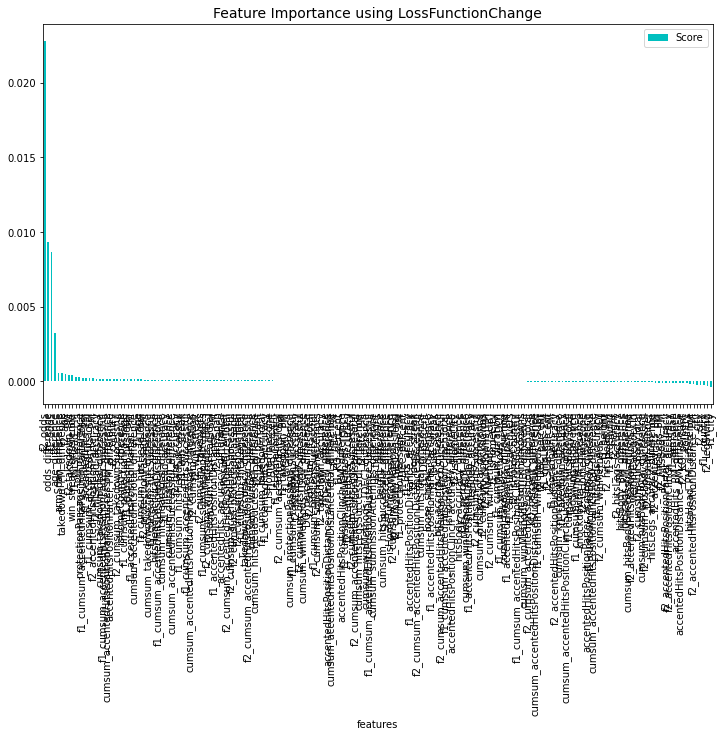

In [21]:
from catboost import Pool
import matplotlib.pyplot as plt

fi = clf1.get_feature_importance(Pool(X_val, label=y_val, cat_features=[0,1,2,3,4,5,6,7]),
                                type='LossFunctionChange')

feature_score1 = pd.DataFrame(list(zip(X_val.dtypes.index, fi)),
                                columns=['Feature','Score'])

feature_score1 = feature_score1.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score1.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Feature Importance using {}".format('LossFunctionChange'), fontsize = 14)
ax.set_xlabel("features")
plt.show()

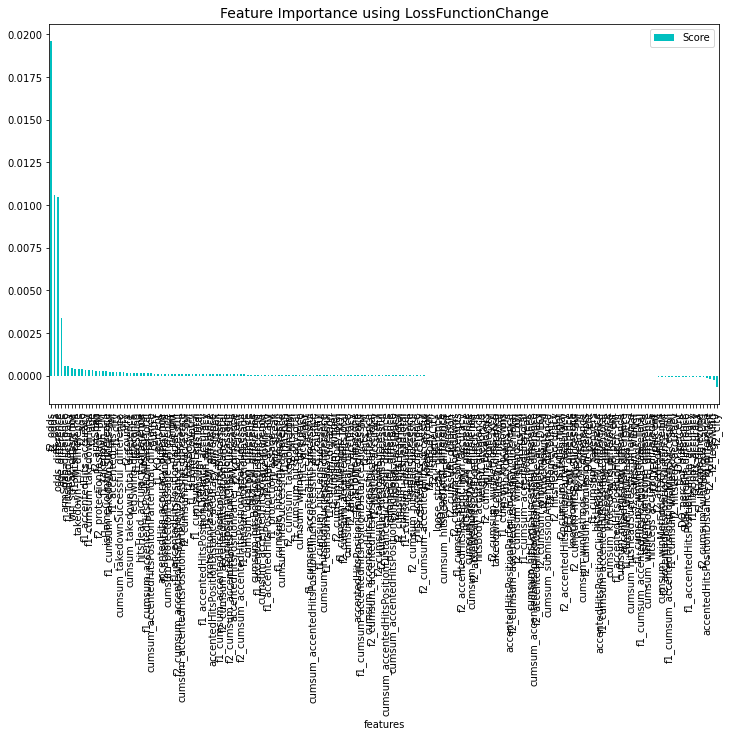

In [22]:
fi = clf2.get_feature_importance(Pool(X_val, label=y_val, cat_features=[0,1,2,3,4,5,6,7]),
                                type='LossFunctionChange')

feature_score2 = pd.DataFrame(list(zip(X_val.dtypes.index, fi)),
                                columns=['Feature','Score'])

feature_score2 = feature_score2.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score2.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Feature Importance using {}".format('LossFunctionChange'), fontsize = 14)
ax.set_xlabel("features")
plt.show()

In [23]:
features1 = feature_score1[feature_score1['Score'] >= 0]
features2 = feature_score2[feature_score2['Score'] >= 0]
features1

,Feature,Score
124,f2_odds,2.279819e-02
186,odds_difference,9.335555e-03
62,f1_odds,8.672860e-03
187,age_difference,3.223009e-03
189,armSpan_difference,5.593519e-04
...,...,...
40,f1_hitsBody_accuracy,4.122462e-06
73,f2_cumsum_hitsSuccessful,7.753959e-07
148,cumsum_hitsLegsTotal_difference,7.212831e-07
80,f2_cumsum_knockdowns,0.000000e+00


In [24]:
train_cols = set(features1['Feature']) & set(features2['Feature'])
train_cols = features1['Feature']#.drop('odds_difference', axis=1)
train_cols.tolist()

['f2_odds',
 'odds_difference',
 'f1_odds',
 'age_difference',
 'armSpan_difference',
 'takedown_PM_difference',
 'f2_age',
 'f2_takedown_PM',
 'win_streak_difference',
 'f1_hitsHead_PM',
 'protectionPassage_PM_difference',
 'f1_cumsum_accentedHitsPositionParterTotal',
 'f1_accentedHits_PM',
 'f1_cumsum_accentedHitsTotal',
 'f2_accentedHitsPositionParter_PM',
 'f2_hitsHead_accuracy',
 'cumsum_takedownTotal_difference',
 'f1_cumsum_accentedHitsPositionParterSuccessful',
 'cumsum_accentedHitsPositionParterSuccessful_difference',
 'accentedHitsPositionParter_PM_difference',
 'f2_country',
 'f2_cumsum_takedownSuccessful',
 'isHomeCountry_difference',
 'f1_cumsum_protectionPassage',
 'f1_cumsum_hitsTotal',
 'f1_accentedHitsPositionParter_PM',
 'cumsum_accentedHitsTotal_difference',
 'f1_age',
 'f1_cumsum_hitsHeadTotal',
 'f2_protectionPassage_PM',
 'cumsum_takedownSuccessful_difference',
 'f1_cumsum_hitsSuccessful',
 'hitsHead_accuracy_difference',
 'f1_cumsum_accentedHitsPositionDistanceTo

In [25]:
features1[['Feature']]

,Feature
124,f2_odds
186,odds_difference
62,f1_odds
187,age_difference
189,armSpan_difference
...,...
40,f1_hitsBody_accuracy
73,f2_cumsum_hitsSuccessful
148,cumsum_hitsLegsTotal_difference
80,f2_cumsum_knockdowns
